In [1]:
# import functions from ../definitions/definitions_EDA
from datetime import timedelta
import sys
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
sys.path.append('../definitions')
import definitions_EDA as eda
# import definitions_plotting as def_plot
from scipy.fft import fft, ifft, fftfreq
from scipy.ndimage import gaussian_filter1d
from scipy import signal
import shutil
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse
from pandas.plotting import autocorrelation_plot
from scipy.signal import find_peaks


Define Variables

In [2]:
start_date = '2024-03-28'
end_date = '2024-04-03'

Fetch data and store as dataframe (data ingestion)

In [3]:
data_arr_mag = eda.process_data(eda.get_data('ctumag', eda.read_txt_file, start_date, end_date))
data_arr_squid = eda.process_data(eda.get_data('squid', eda.read_txt_file, start_date, end_date))
df = eda.create_dataframe(data_arr_mag, data_arr_squid, start_date)
# df = df.between_time('12:30:00', '13:30:00') # Select only a small subset of the data for analysis
# print(f' \n Shape of df', df.shape)
print(f' \nNumber of days data = Total records {df.shape[0]} / records per day (431998) = {df.shape[0]/431998} ')
print(f' \nHead of dataframe: \n', df.head().to_string(index=True))

The total number of duplicates is: 481361
 
Number of days data = Total records 3023981 / records per day (431998) = 6.999988425872342 
 
Head of dataframe: 
                          NS_SQUID   F_SQUID  NS_Fluxgate  EW_Fluxgate  Z_Fluxgate
2024-03-28 00:00:00.200  190.5905  138.7691   10945.6927     -76.3286 -22673.4826
2024-03-28 00:00:00.400  190.5909  138.7664   10945.6927     -76.3286 -22673.4826
2024-03-28 00:00:00.600  190.5927  138.7652   10945.6915     -76.2966 -22673.4709
2024-03-28 00:00:00.800  190.5922  138.7646   10945.6833     -76.2972 -22673.4569
2024-03-28 00:00:01.000  190.5932  138.7712   10945.6833     -76.2972 -22673.4569


Plot the raw data

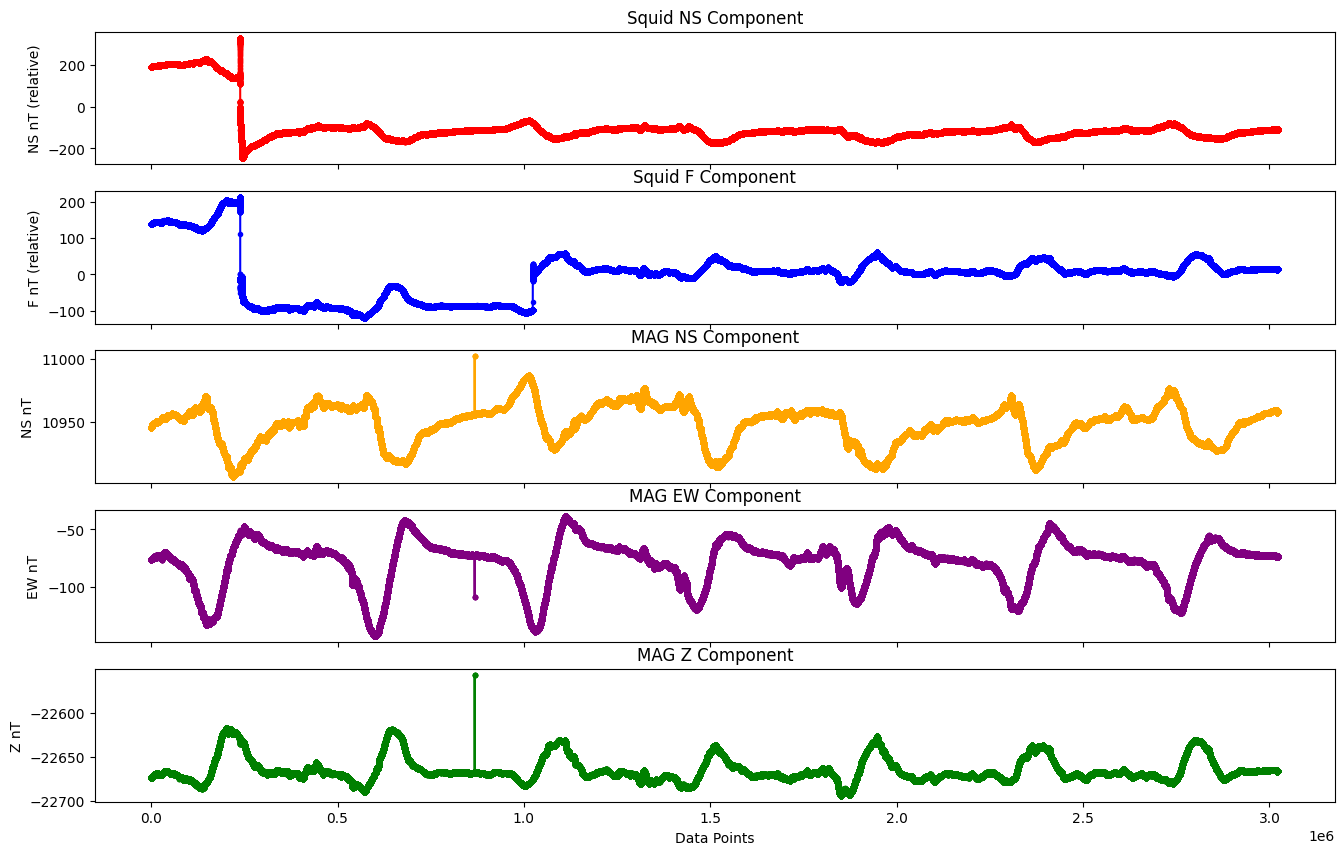

In [4]:
eda.generateDataPlots(df['NS_SQUID'].values, df['F_SQUID'].values, df['NS_Fluxgate'].values, df['EW_Fluxgate'].values, df['Z_Fluxgate'].values, df.shape[0], 431997, start_date, end_date)


As we can see there are severe drops in the squid data. Lets fix these

Fix sudden drops or jumps in SQUID data

DatetimeIndex(['2024-03-29 12:33:51.070000', '2024-03-29 12:33:51.270000',
               '2024-03-29 12:33:54.070000', '2024-03-29 12:33:54.470000'],
              dtype='datetime64[ns]', freq=None)
Spikes detected at indices: DatetimeIndex(['2024-03-29 12:33:51.070000', '2024-03-29 12:33:51.270000',
               '2024-03-29 12:33:54.070000', '2024-03-29 12:33:54.470000'],
              dtype='datetime64[ns]', freq=None)
4
DatetimeIndex(['2024-03-29 12:33:51.070000', '2024-03-29 12:33:51.270000',
               '2024-03-29 12:33:53.870000', '2024-03-29 12:33:54.070000',
               '2024-03-29 12:33:54.470000', '2024-03-28 23:40:26.370000',
               '2024-03-28 23:40:26.570000', '2024-03-28 23:41:40.770000'],
              dtype='datetime64[ns]', freq=None)
Spikes detected at indices: DatetimeIndex(['2024-03-29 12:33:51.070000', '2024-03-29 12:33:51.270000',
               '2024-03-29 12:33:53.870000', '2024-03-29 12:33:54.070000',
               '2024-03-29 12:33:54.470000

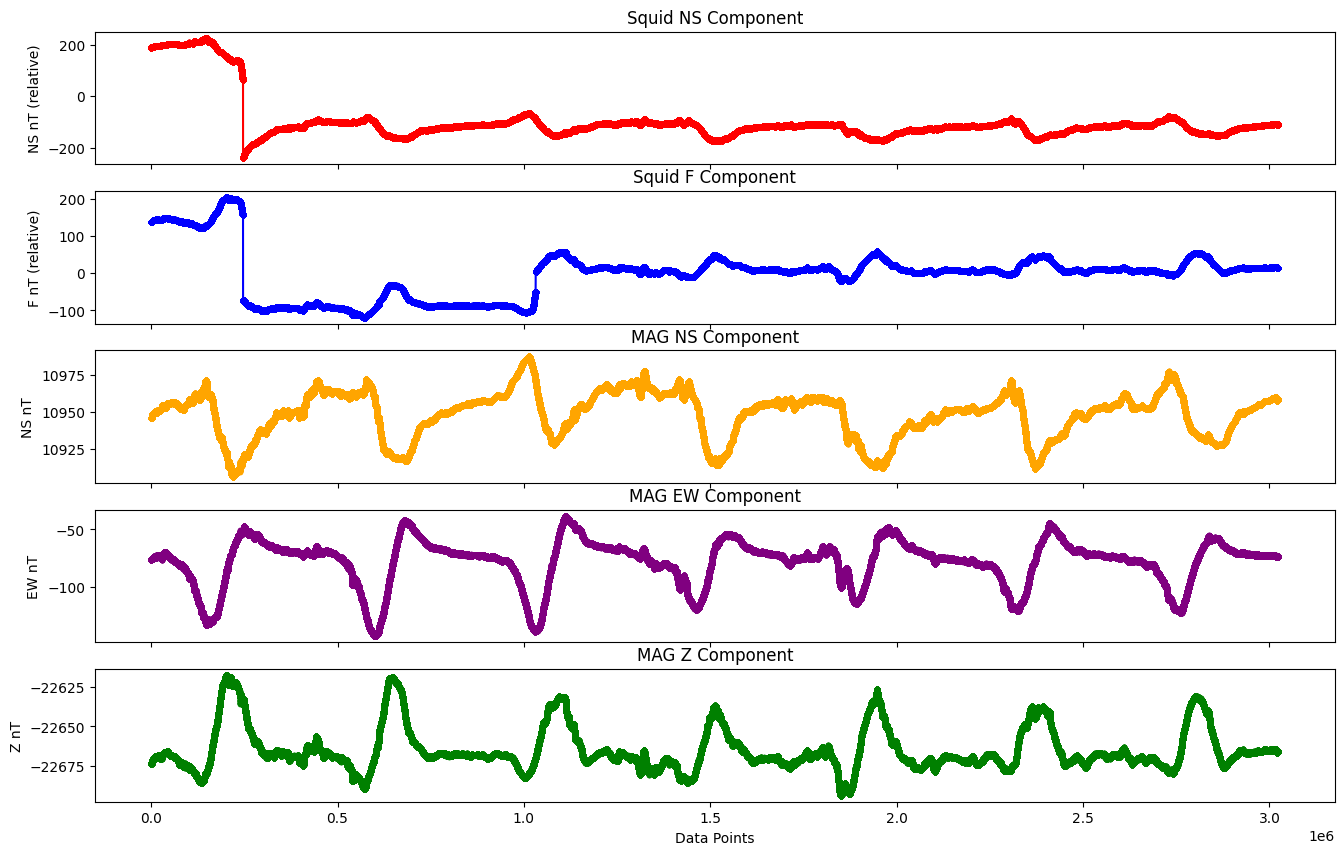

In [5]:
def detect_spikes_and_correct(df, column_name, threshold=15):
    """
    Detects spikes in the data and smooths them by adjusting the spike value.

    Parameters:
    - df (pd.DataFrame): The DataFrame containing the data.
    - column_name (str): The name of the column to check for spikes.
    - threshold (float): The threshold for detecting spikes in terms of standard deviations.

    Returns:
    - corrected_df (pd.DataFrame): The DataFrame with the spikes corrected.
    """

    # Ensure the DataFrame index is a DatetimeIndex
    if not isinstance(df.index, pd.DatetimeIndex):
        raise ValueError("The DataFrame index must be a DatetimeIndex.")
    
    # Calculate the difference between consecutive values
    diff = df[column_name].diff()

    # Detect spikes by finding where the difference exceeds the threshold
    # std_dev = diff.std()
    spikes = diff.abs() > threshold # * std_dev
    # print(spikes)
    # Get the indices where spikes occur
    spike_indices = spikes[spikes].index
    print(spike_indices)
    if len(spike_indices) == 0:
        print("No spikes detected.")
        return df

    print(f"Spikes detected at indices: {spike_indices}")
    print(len(spike_indices))
    corrected_df = df.copy()

    for index in spike_indices:
        # Find the positions before and after the spike
        prev_index = corrected_df.index.get_loc(index) - 7500
        next_index = corrected_df.index.get_loc(index) + 7500
 
        # my_window = next_index - prev_index
        my_window = 4000


        smoothed_values = corrected_df.iloc[prev_index:next_index + 1, corrected_df.columns.get_loc(column_name)].rolling(window=my_window, min_periods=1).mean()
        smoothed_values = gaussian_filter1d(smoothed_values, sigma=2000)
        corrected_df.iloc[prev_index:next_index + 1, corrected_df.columns.get_loc(column_name)] = smoothed_values
        # Apply moving average only between prev_index and next_index
        # corrected_df.iloc[prev_index:next_index, corrected_df.columns.get_loc(column_name)] = corrected_df.iloc[prev_index:next_index, corrected_df.columns.get_loc(column_name)].rolling(window=my_window).mean()

    return corrected_df

corrected_df_ns = detect_spikes_and_correct(df, "NS_SQUID")
corrected_df_f = detect_spikes_and_correct(corrected_df_ns, "F_SQUID")
corrected_df_nf = detect_spikes_and_correct(corrected_df_f, "NS_Fluxgate")
corrected_df_ew = detect_spikes_and_correct(corrected_df_nf, "EW_Fluxgate")
corrected_df = detect_spikes_and_correct(corrected_df_ew, "Z_Fluxgate")



eda.generateDataPlots(corrected_df['NS_SQUID'].values, corrected_df['F_SQUID'].values, corrected_df['NS_Fluxgate'].values, corrected_df['EW_Fluxgate'].values, corrected_df['Z_Fluxgate'].values, corrected_df.shape[0], 431997, start_date, end_date)
# corrected_df_f = detect_spikes_and_correct(corrected_df_ns, "F_SQUID")

Check for missing values and zero values

In [6]:
for column in df.columns:
    print(f"\n Number of missing values in {column} is: ", df[column].isna().sum())
    print(f"Nmber of zeros in {column} is: ", (df[column] == 0).sum())



 Number of missing values in NS_SQUID is:  0
Nmber of zeros in NS_SQUID is:  0

 Number of missing values in F_SQUID is:  0
Nmber of zeros in F_SQUID is:  2

 Number of missing values in NS_Fluxgate is:  0
Nmber of zeros in NS_Fluxgate is:  0

 Number of missing values in EW_Fluxgate is:  0
Nmber of zeros in EW_Fluxgate is:  0

 Number of missing values in Z_Fluxgate is:  0
Nmber of zeros in Z_Fluxgate is:  0


### Choose on of the following 2 outlier tests

Z score test

 
 Shape of df before removing outliers (3023981, 5)
                                F_SQUID  NS_Fluxgate  EW_Fluxgate  Z_Fluxgate
2024-03-28 00:00:00.200000000  2.135100     0.185706     0.070132    0.625699
2024-03-28 00:00:00.400000000  2.135058     0.185706     0.070132    0.625699
2024-03-28 00:00:00.600000000  2.135040     0.185783     0.071726    0.624875
2024-03-28 00:00:00.800000000  2.135031     0.186310     0.071696    0.623889
2024-03-28 00:00:01.000000000  2.135132     0.186310     0.071696    0.623889
...                                 ...          ...          ...         ...
2024-03-30 17:32:39.120000001  0.228323     0.631850     0.200412    0.115016
2024-03-30 17:32:39.320000001  0.228431     0.631850     0.200412    0.115016
2024-03-30 17:32:39.520000001  0.228369     0.633084     0.214991    0.117333
2024-03-30 17:32:39.720000001  0.228146     0.633084     0.214991    0.117333
2024-03-30 17:32:39.920000001  0.228355     0.633804     0.220600    0.116748

[3023981 r

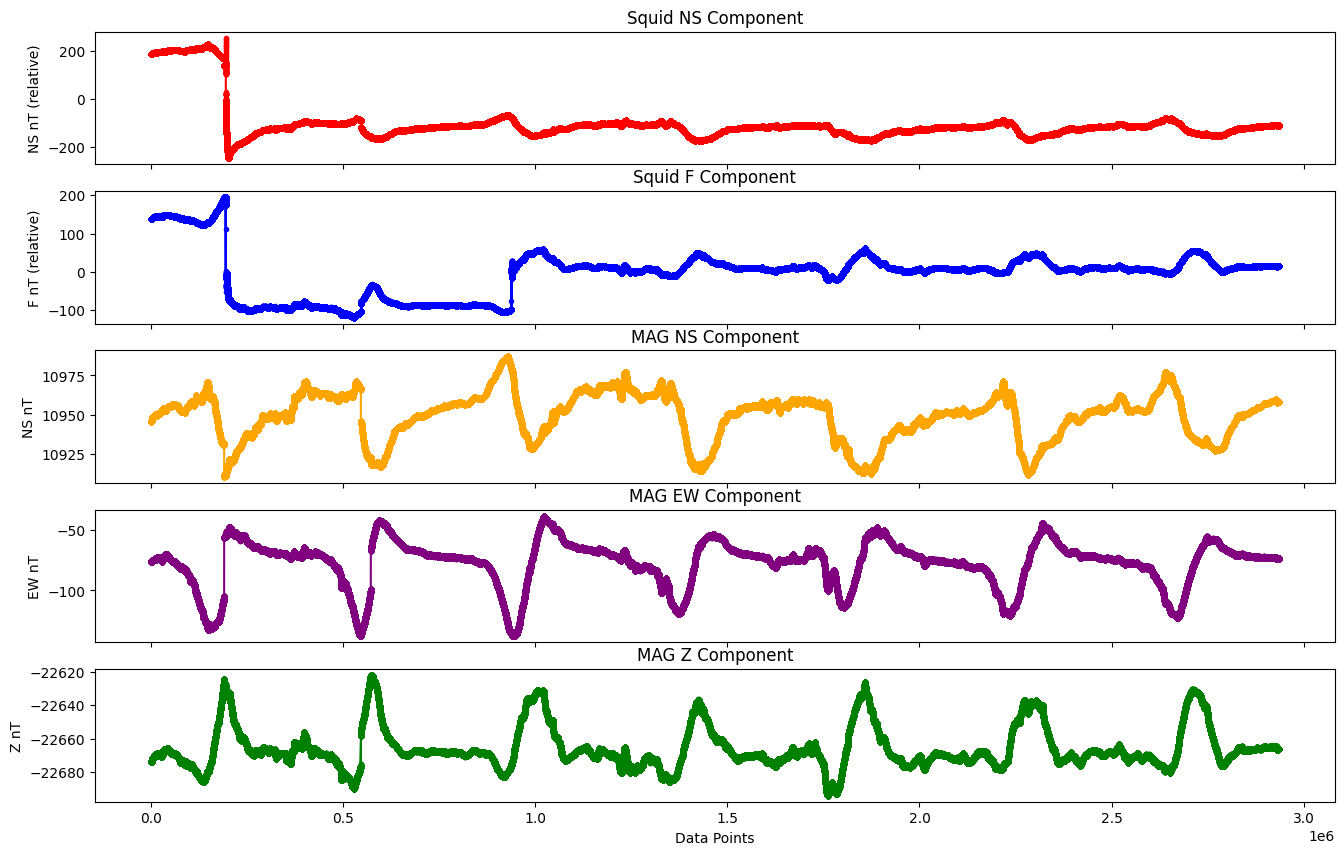

In [7]:
print(f' \n Shape of df before removing outliers', df.shape)
outliers_removed_z = eda.z_score_test(df)
print(f' \n Shape of df after removing outliers', outliers_removed_z.shape)
eda.generateDataPlots(outliers_removed_z['NS_SQUID'].values, outliers_removed_z['F_SQUID'].values, outliers_removed_z['NS_Fluxgate'].values, outliers_removed_z['EW_Fluxgate'].values, outliers_removed_z['Z_Fluxgate'].values, outliers_removed_z.shape[0], 431997, start_date, end_date)


Interquatile range check

In [8]:
print(f' \n Shape of df before removing outliers', df.shape)
outliers_removed_iqr = eda.remove_outliers(df)
print(f' \n Shape of df after removing outliers', outliers_removed_iqr.shape)
print(f"Percentage of removed outliers: {((df.shape[0] - outliers_removed_iqr.shape[0])/df.shape[0])*100 }%")
print(outliers_removed_iqr.head(20))

 
 Shape of df before removing outliers (3023981, 5)
Number of outliers removed:
 NS_SQUID       252741
F_SQUID         85356
NS_Fluxgate         0
EW_Fluxgate    138169
Z_Fluxgate     251781
dtype: int64
 
 Shape of df after removing outliers (2490507, 5)
Percentage of removed outliers: 17.64144682125979%
                         NS_SQUID  F_SQUID  NS_Fluxgate  EW_Fluxgate  \
2024-03-29 15:18:21.290 -210.5135 -81.9846   10921.2429     -52.2470   
2024-03-29 15:18:21.490 -210.5035 -81.9682   10921.2429     -52.2470   
2024-03-29 15:18:21.690 -210.4936 -81.9668   10921.2699     -52.2172   
2024-03-29 15:18:21.890 -210.4837 -81.9507   10921.2699     -52.2172   
2024-03-29 15:18:22.090 -210.4722 -81.9289   10921.2814     -52.2262   
2024-03-29 15:18:22.290 -210.4693 -81.9216   10921.3098     -52.1779   
2024-03-29 15:18:22.490 -210.4608 -81.9026   10921.3098     -52.1779   
2024-03-29 15:18:22.690 -210.4484 -81.8943   10921.3328     -52.2187   
2024-03-29 15:18:22.890 -210.4457 -81.6419  

In [9]:
for column in outliers_removed_iqr.columns:
    time_indices_with_zeros = outliers_removed_iqr[outliers_removed_iqr[column] == 0].index
    print(f"Time indices with zeros in {column}:")
    print(time_indices_with_zeros)
    print()

Time indices with zeros in NS_SQUID:
DatetimeIndex([], dtype='datetime64[ns]', freq=None)

Time indices with zeros in F_SQUID:
DatetimeIndex(['2024-03-28 17:20:42.270000', '2024-03-30 09:05:23.190000'], dtype='datetime64[ns]', freq=None)

Time indices with zeros in NS_Fluxgate:
DatetimeIndex([], dtype='datetime64[ns]', freq=None)

Time indices with zeros in EW_Fluxgate:
DatetimeIndex([], dtype='datetime64[ns]', freq=None)

Time indices with zeros in Z_Fluxgate:
DatetimeIndex([], dtype='datetime64[ns]', freq=None)



Now choose a dataframe to continue calculation with

In [10]:
out_removed_df = outliers_removed_z
# out_removed_df = outliers_removed_iqr
print(out_removed_df.resample('s').count().head(20))

                     NS_SQUID  F_SQUID  NS_Fluxgate  EW_Fluxgate  Z_Fluxgate
2024-03-28 00:00:00        34       34           34           34          34
2024-03-28 00:00:01        35       35           35           35          35
2024-03-28 00:00:02        35       35           35           35          35
2024-03-28 00:00:03        35       35           35           35          35
2024-03-28 00:00:04        35       35           35           35          35
2024-03-28 00:00:05        35       35           35           35          35
2024-03-28 00:00:06        35       35           35           35          35
2024-03-28 00:00:07        35       35           35           35          35
2024-03-28 00:00:08        35       35           35           35          35
2024-03-28 00:00:09        35       35           35           35          35
2024-03-28 00:00:10        35       35           35           35          35
2024-03-28 00:00:11        35       35           35           35          35

Plot after outlier removed

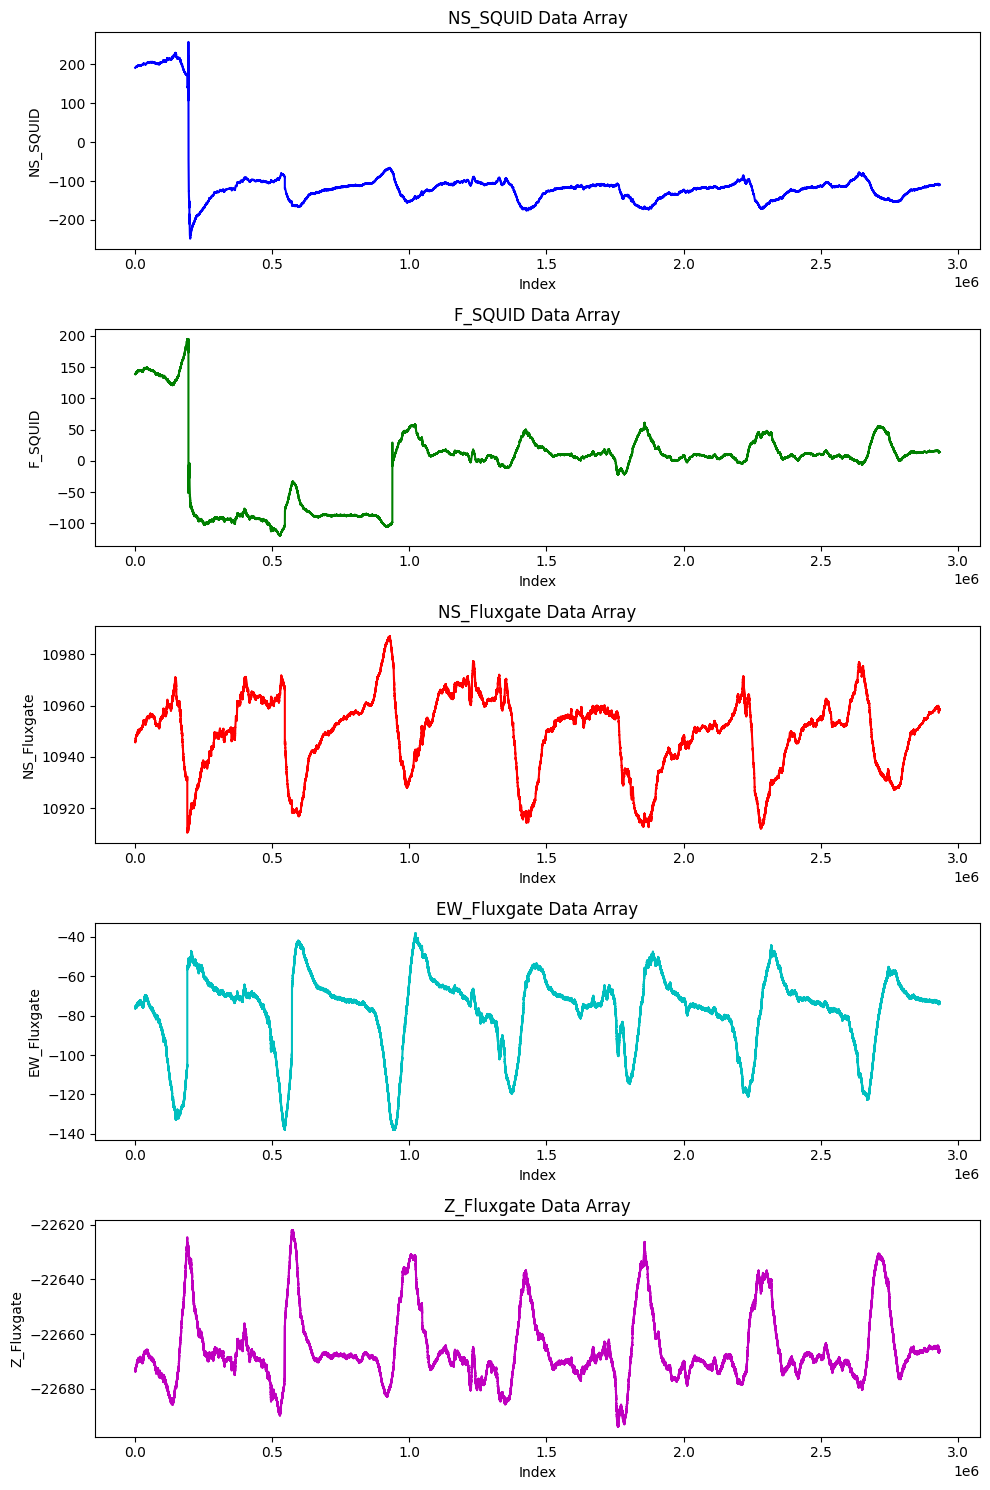

In [11]:
eda.plot_cleaned_data(out_removed_df)

Resample data

In [12]:
print(f' \n Shape of df', out_removed_df.shape)
resampled_df = eda.manual_resample_data(out_removed_df, 's')
print(f"\n Shape of new resampled dataframe is:", resampled_df.shape)
print(f"\n The number of records we should have is: {round(out_removed_df.shape[0]/5)}")
print(resampled_df.resample('s').count().head())
eda.generateDataPlots(resampled_df['NS_SQUID'].values, resampled_df['F_SQUID'].values, resampled_df['NS_Fluxgate'].values, resampled_df['EW_Fluxgate'].values, resampled_df['Z_Fluxgate'].values, resampled_df.shape[0], 431997, start_date, end_date)


 
 Shape of df (2934882, 5)
Number of missing values before dropping rows: 0
Number of missing values after dropping rows: 0

 Shape of new resampled dataframe is: (86400, 5)

 The number of records we should have is: 586976


TypeError: Only valid with DatetimeIndex, TimedeltaIndex or PeriodIndex, but got an instance of 'MultiIndex'

In [ ]:
eda.plot_cleaned_data(resampled_df)

Test for stationarity

In [ ]:
eda.perform_dickey_fuller_test(df)

Now perform differencing on data to ensure stationarity

In [ ]:
df_differenced = resampled_df.diff().dropna()
# print(f"This is the difference dataframe:\n",df_differenced)
eda.perform_dickey_fuller_test(resampled_df)

Test for seasonality and trend

Analyzing column: NS_SQUID


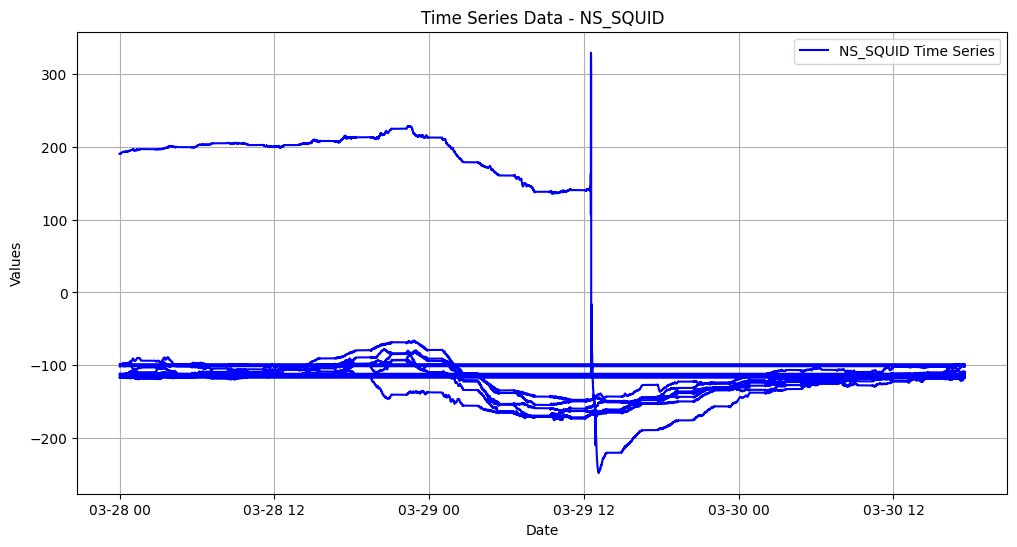

Decomposing the time series for column: NS_SQUID
Error decomposing NS_SQUID: You must specify a period or x must be a pandas object with a PeriodIndex or a DatetimeIndex with a freq not set to None
Analyzing column: F_SQUID


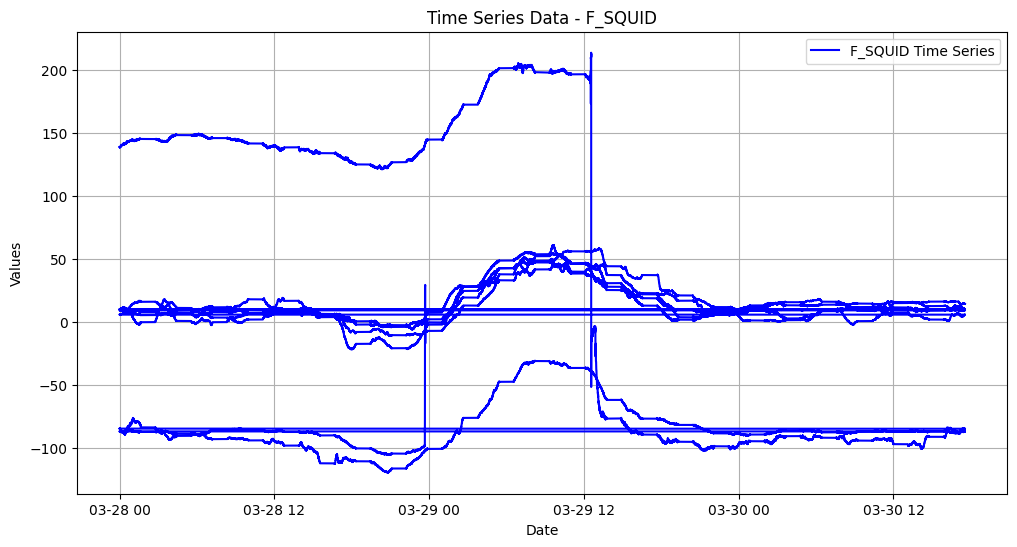

Decomposing the time series for column: F_SQUID
Error decomposing F_SQUID: You must specify a period or x must be a pandas object with a PeriodIndex or a DatetimeIndex with a freq not set to None
Analyzing column: NS_Fluxgate


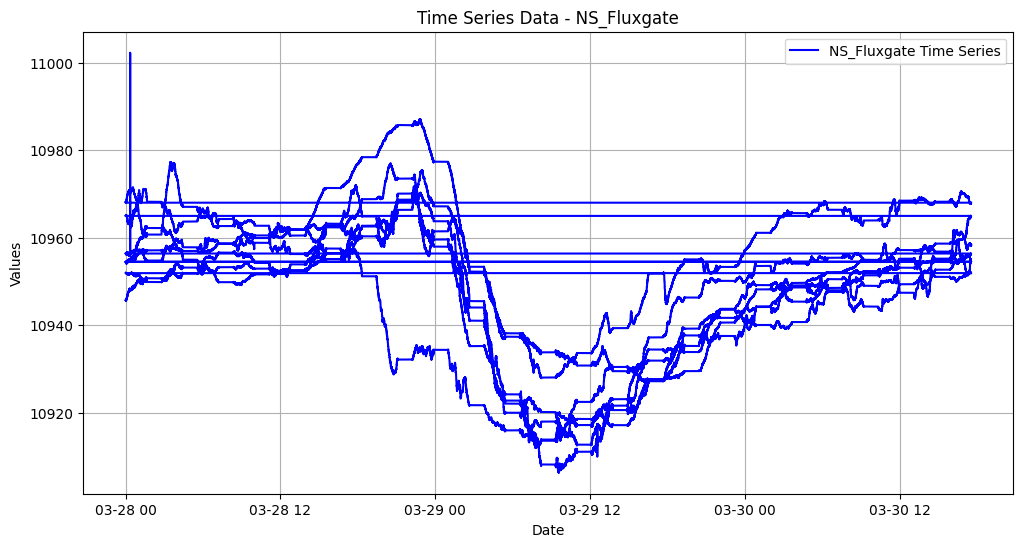

Decomposing the time series for column: NS_Fluxgate
Error decomposing NS_Fluxgate: You must specify a period or x must be a pandas object with a PeriodIndex or a DatetimeIndex with a freq not set to None
Analyzing column: EW_Fluxgate


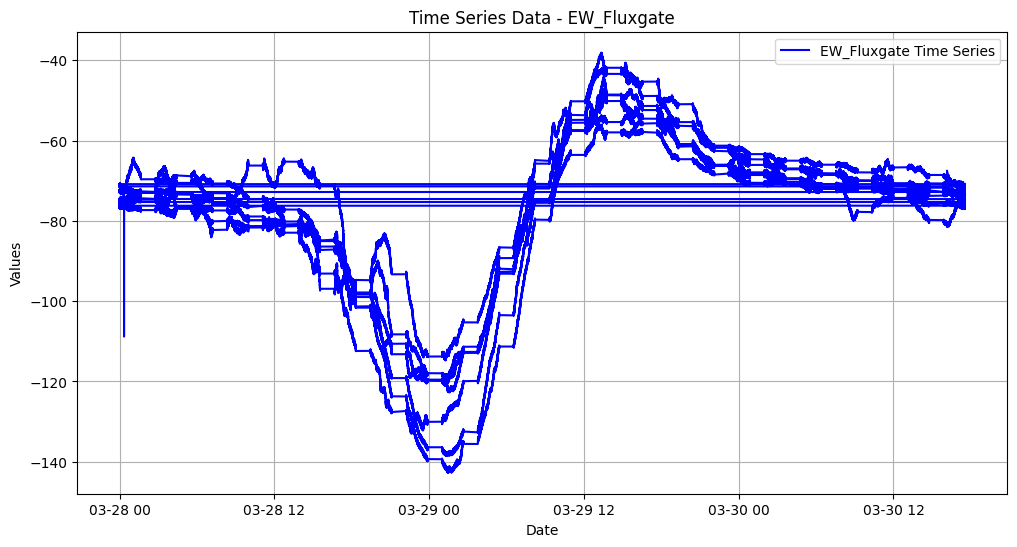

Decomposing the time series for column: EW_Fluxgate
Error decomposing EW_Fluxgate: You must specify a period or x must be a pandas object with a PeriodIndex or a DatetimeIndex with a freq not set to None
Analyzing column: Z_Fluxgate


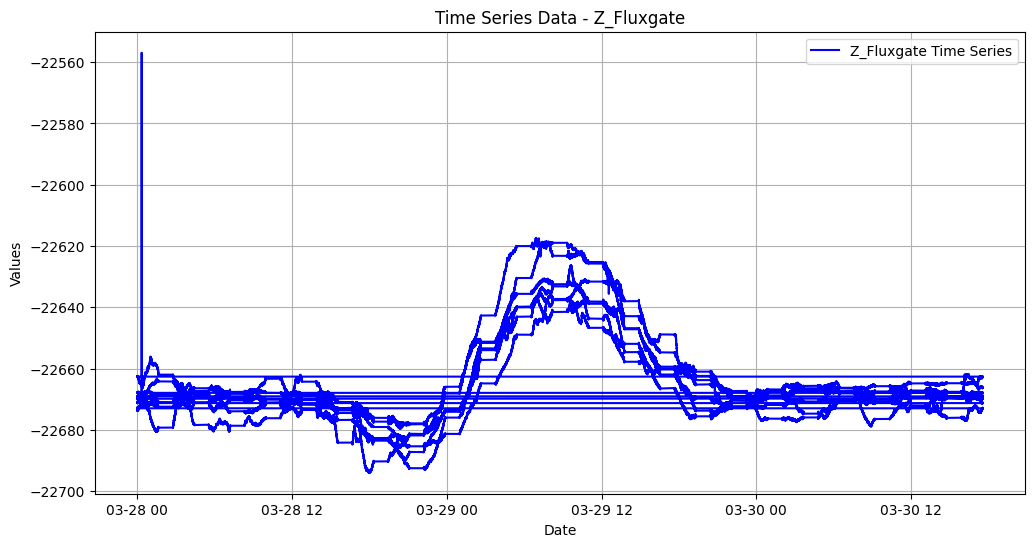

Decomposing the time series for column: Z_Fluxgate
Error decomposing Z_Fluxgate: You must specify a period or x must be a pandas object with a PeriodIndex or a DatetimeIndex with a freq not set to None


{}

In [14]:
eda.test_stationarity(df)

Now using the autocorrelation_plot

In [ ]:
# Draw Plot
plt.rcParams.update({'figure.figsize':(9,5), 'figure.dpi':120})
autocorrelation_plot(df['EW_Fluxgate'].tolist())

Fourier Transform

In [ ]:
components, fourier_results = eda.calculate_fourier_transforms(df)
eda.plot_fourier_transform(fourier_results, components)

Write the preprocessed dataframe to a file

In [ ]:
df.to_csv('/Users/tristan/Library/CloudStorage/OneDrive-StellenboschUniversity/Academics/Final_year/Semester 2/Skripsie/Data/RESAMPLED/df.csv', index=True)

Create a pdf for each of the columns in the df

In [ ]:
import seaborn as sns

for column in df.columns:
    sns.displot(df[column], kde=True)

Decompose time series into its components

In [ ]:
# Additive Decomposition
# result_add = seasonal_decompose(df['Z_Fluxgate'], model='additive', extrapolate_trend='freq')

# Plot
# plt.rcParams.update({'figure.figsize': (10,10)})
# result_add.plot().suptitle('Additive Decompose', fontsize=22)
# plt.show()